<a href="https://colab.research.google.com/github/KevinRobledo123/Robot-Trading/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Challenge 1: Robot Trading
Por: Kevin Robledo

## Paso 1: Confiuración del ambiente

In [1]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

In [2]:
#Versiones de las bibliotecas
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


##Paso 2: Obtención de datos

In [3]:
#Importar las bibliotecas necesarias
import yfinance as yf
from bs4 import BeautifulSoup
import requests

###2.1. Precios históricos del bitcoin

La biblioteca yfinance es una herramienta de Python que permite descargar datos financieros de Yahoo Finance.

In [4]:
#Definimos la función importar_base_bitcoin() 
def importar_base_bitcoin():
  global df_bitcoin
  #Usando el método download para obtener el precio histórico de los últimoss 7 días en intervalos de 5 min
  data = yf.download("BTC-USD", period="7d", interval="5m")

  #Guardar los datos en un dataframe
  df_bitcoin = pd.DataFrame(data)

  return df_bitcoin

### 2.2. Indicadores de tendencias

In [5]:
#Definimos la función extraer_tendencias()
def extraer_tendencias():
  global precio_actual,tendencia
  #Configuramos el scrapping
  url = 'https://coinmarketcap.com/'
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'lxml')

  #Obtener el precio actual
  precio_btc = soup.find('a', class_='cmc-link').get_text()
  #Guardar el precio en float en la variable precio_actual
  precio_btc = precio_btc.replace(',', '')
  precio_actual = float(precio_btc)  

  #Obtener si la variación es positiva o negativa
  icon = soup.find('span', class_=['icon-Caret-down', 'icon-Caret-up'])
  if 'icon-Caret-up' in icon:
    tendencia = 'alta'
  else:
    tendencia = 'baja'

  #Obtener la variación en la última hora
  variacion = soup.find('span', class_='sc-97d6d2ca-0 cYiHal').get_text()

  return [precio_actual, tendencia, variacion]

In [6]:
importar_base_bitcoin()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-11 00:00:00+00:00,27621.085938,27621.085938,27603.746094,27618.919922,27618.919922,0
2023-05-11 00:05:00+00:00,27616.986328,27621.716797,27606.728516,27621.716797,27621.716797,2836480
2023-05-11 00:10:00+00:00,27613.509766,27621.941406,27608.042969,27618.173828,27618.173828,17080320
2023-05-11 00:15:00+00:00,27615.425781,27621.072266,27601.732422,27603.158203,27603.158203,18374656
2023-05-11 00:20:00+00:00,27603.869141,27603.869141,27535.539062,27575.632812,27575.632812,15005696
...,...,...,...,...,...,...
2023-05-17 01:15:00+00:00,27072.896484,27072.896484,27060.970703,27060.970703,27060.970703,19663872
2023-05-17 01:20:00+00:00,27071.781250,27077.103516,27064.261719,27077.103516,27077.103516,327680
2023-05-17 01:25:00+00:00,27079.550781,27094.375000,27079.550781,27094.375000,27094.375000,0


In [7]:
extraer_tendencias()

[24209.0, 'baja', '0.33%']

##Paso 3: Limpieza de datos

In [8]:
import seaborn as sns
import numpy as np

In [9]:
#Definimos la función limpieza_datos()
def limpieza_datos():
  global media_bitcoin,df_bitcoin_limpio
  df = importar_base_bitcoin()
  #Creamos una copia para poder realizar la limpieza
  df_bitcoin_limpio = df.copy()

  #Eliminar los valores duplicados en el índice
  indices_unicos = df_bitcoin_limpio.index.drop_duplicates()
  df_bitcoin_limpio = df_bitcoin_limpio.reindex(indices_unicos)

  #Eliminar los valores nulos en la columna 'Close'
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True)

  #Mantener únicamente los registros que tengan un Volume > 0
  df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume'] > 0]

  #Eliminar outliers en el precio del Bitcoin
  close = df_bitcoin_limpio['Close']
  Q1 = close.quantile(.25)
  Q3 = close.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((close >= limite_inferior) & (close < limite_superior))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  return df_bitcoin_limpio

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Distribución de precios de bitcoin en dólares')

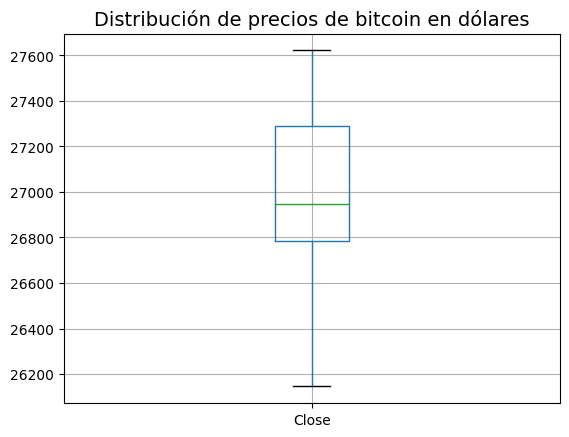

In [10]:
limpieza_datos()
df_bitcoin_limpio.boxplot(['Close'])
plt.title('Distribución de precios de bitcoin en dólares', fontsize=14)

##Paso 4: Tomar decisiones

In [11]:
def tomar_decisiones():
  global df_bitcoin, precio_actual, media_bitcoin, algoritmo_decision, df_bitcoin_limpio

  #Calculamos la media
  media_bitcoin = df_bitcoin_limpio['Close'].mean()

  #Declaramos variables
  #precio_actual = extraer_tendencias()[0]
  #tendencia = extraer_tendencias()[1]

  #Determinamos los criterios
  if ((precio_actual >= media_bitcoin) & (tendencia == 'baja')):
    algoritmo_decision = 'Vender'
  elif ((precio_actual < media_bitcoin) & (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Esperar'
  
  return algoritmo_decision

In [12]:
tomar_decisiones()

'Esperar'

##Paso 5: Visualización

In [13]:
import matplotlib.pyplot as plt

In [14]:
def visualizacion():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio
  #Adicionamos una nueva columna que almacena el valor media_bitcoin
  df_bitcoin['Promedio'] = media_bitcoin

  #Configuramos el tamaño del gráfico
  plt.figure(figsize=(16,5))

  #Título del gráfico
  plt.title('¿Comprar, vender o esperar?', fontsize=14)

  #Dibujamos una línea en el gráfico con los datos del índice y de la columna 'Close'
  df_bitcoin['Close'].plot(legend = None, color = '#326789')

  ##Dibujamos una línea en el gráfico con los datos del índice y de la columna 'Promedio'
  df_bitcoin['Promedio'].plot(legend = None, ls='--', color = '#E65C4F')

  #Mostramos un mensaje con la decisión tomada
  plt.annotate(f'Decisión: {algoritmo_decision}', xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(-180, -150), textcoords='offset points', fontsize=14)

  #Mostramos el gráfico en pantalla
  plt.show()


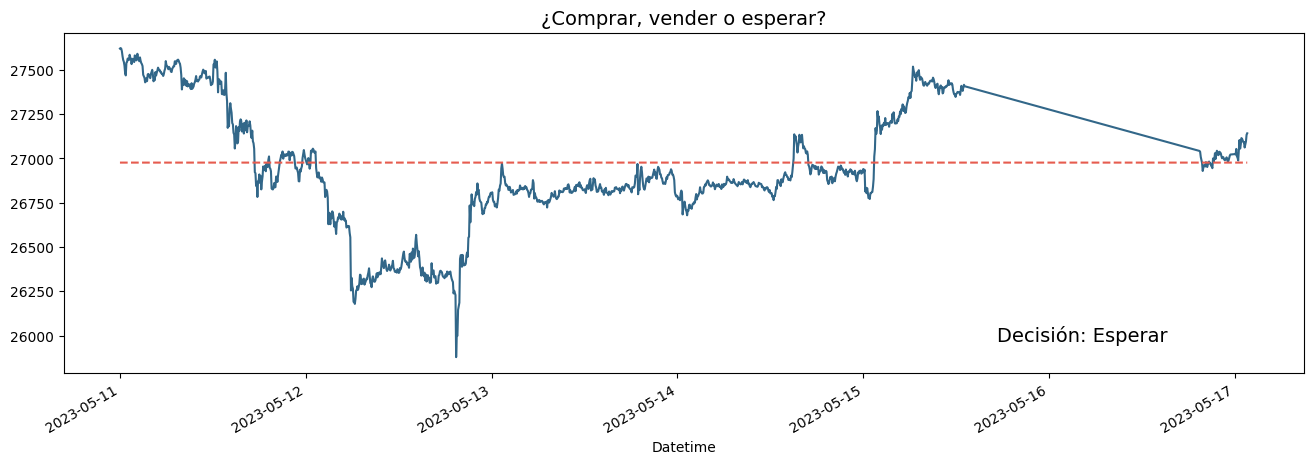

In [15]:
visualizacion()

##Paso 6: Automatización

In [17]:
from IPython.display import clear_output
import time

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


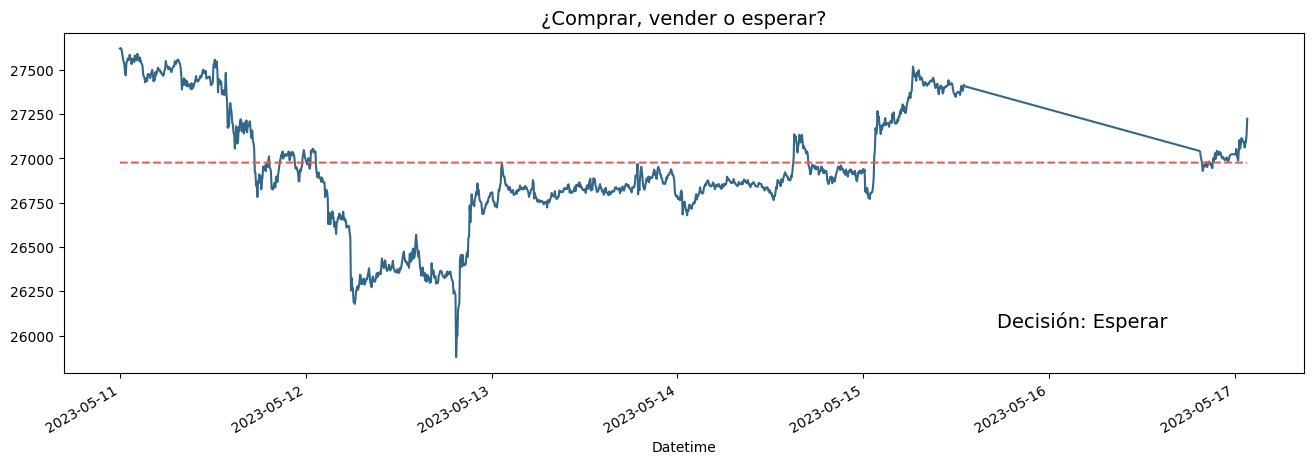

In [ ]:
#Construimos un loop infinito para ejecutar las funciones que hemos construido
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)